In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range
import time
import h5py

import brutus

# plot in-line within the notebook
%matplotlib inline

np.random.seed(300418)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [3]:
# import models and labels
from brutus import filters
filters = filters.gaia + filters.ps + filters.tmass + filters.wise[:2]
version = 'v4.1'
filepath = '../data/grid_' + version + '.h5'
models, labels, label_mask = brutus.load_models(filepath, filters=filters)
Nmodels, Nbands, Ncoef = models.shape

Reading filter WISE_W2                  


In [4]:
# Apply zeropoint correction to match old mocks
models[:,  :3, -1] += np.array([-0.02496, -0.02961, -0.01644])

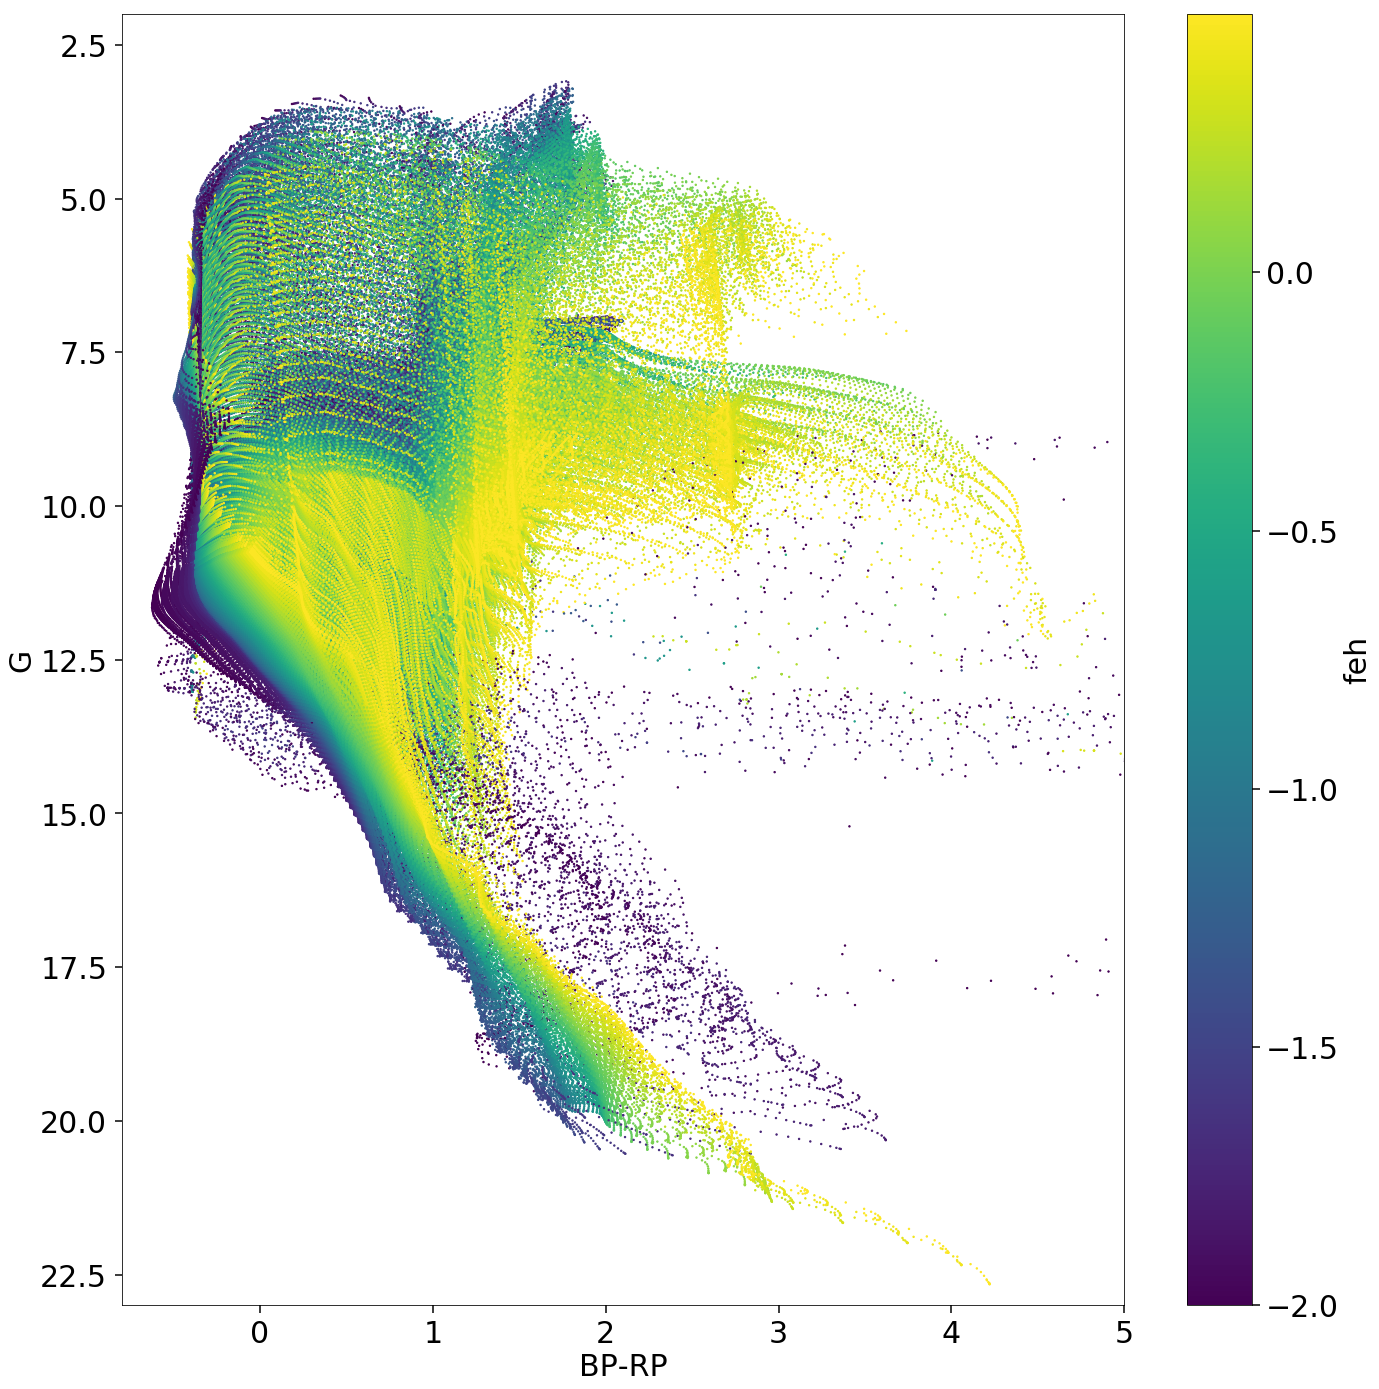

In [5]:
# get unreddened magnitudes
g = models[:, 0, -1]
bp = models[:, 1, -1]
rp = models[:, 2, -1]

# plot CMD
plt.figure(figsize=(20, 20))
plt.scatter(bp - rp, g, c=labels['feh'], s=2)
plt.ylim([23, 2])
plt.xlim([-0.8, 5])
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.colorbar(label='feh')
plt.tight_layout()

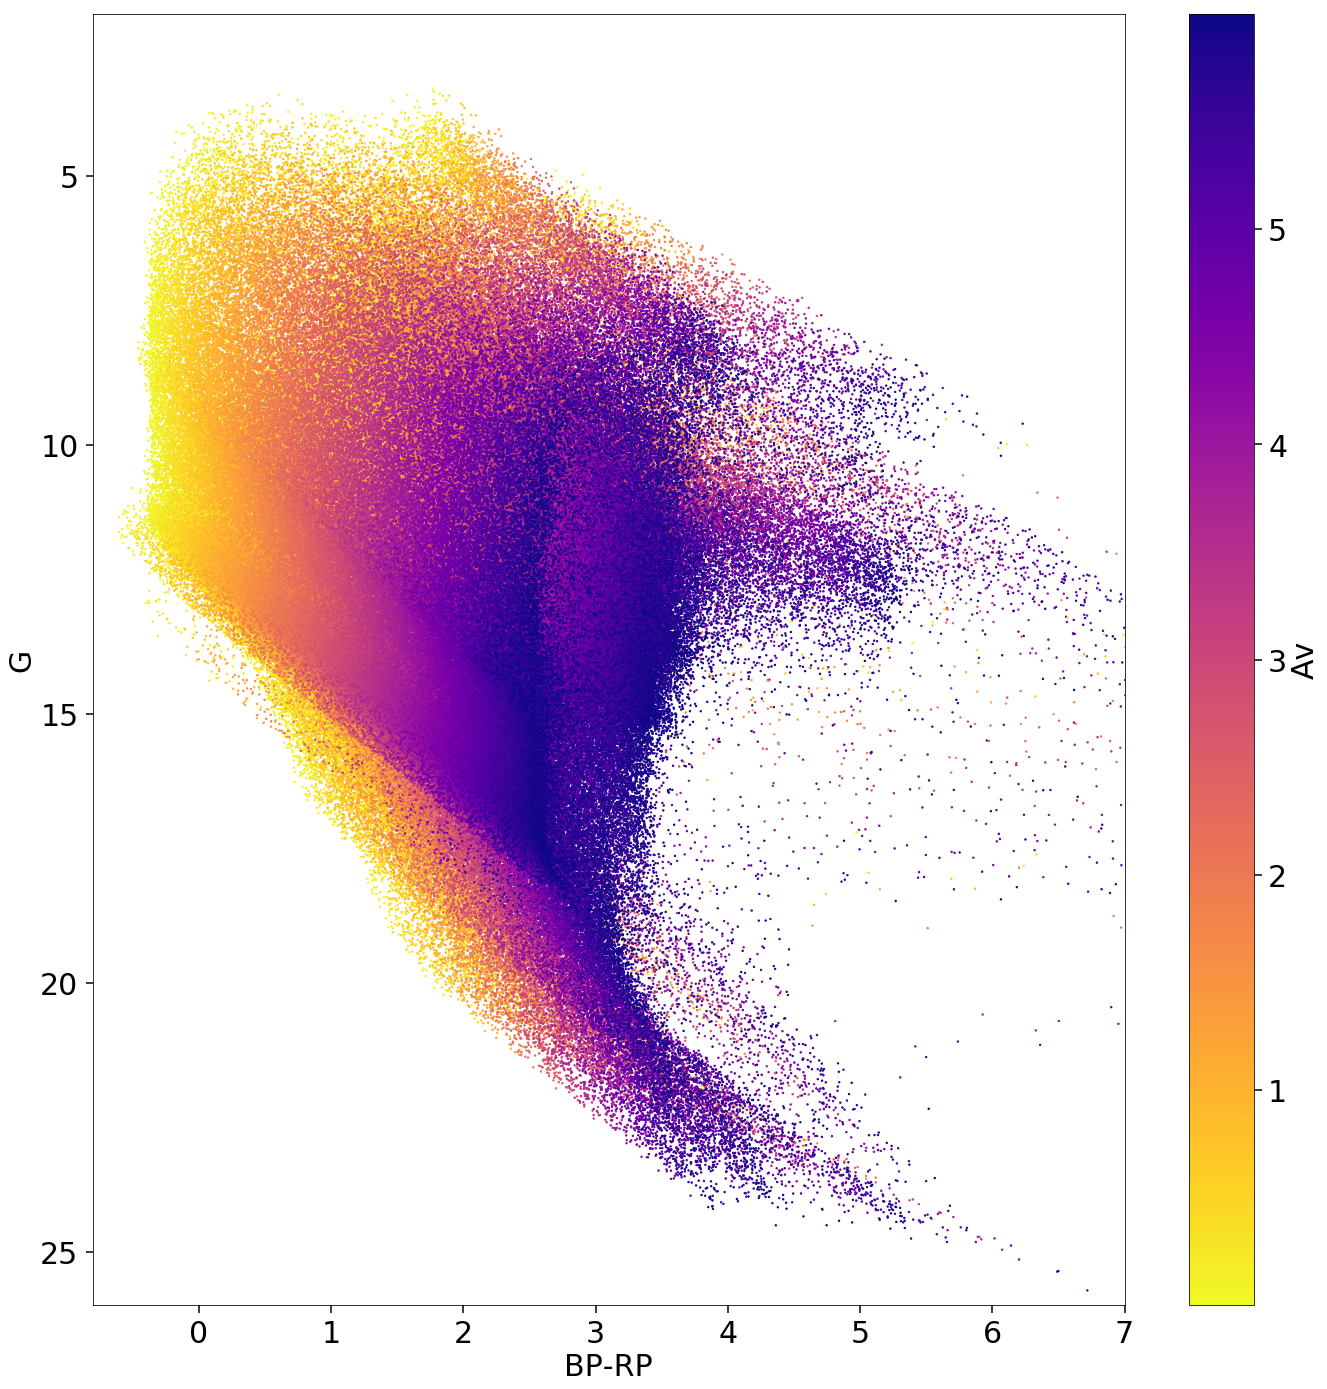

In [6]:
from brutus import fitting

# generate randomly reddened SEDs
av = np.random.rand(Nmodels) * 6.
seds, rvecs = fitting.get_seds(models, av=av, return_rvec=True, return_flux=True)

# plot CMD
g, bp, rp = -2.5 * np.log10(seds[:, :3].T)

# plot CMD
plt.figure(figsize=(20, 20))
plt.scatter((bp-rp), g, c=av, s=2, cmap='plasma_r')
plt.ylim([26, 2])
plt.xlim([-0.8, 7])
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.colorbar(label='Av')
plt.tight_layout()

In [7]:
# load in data
from astropy.table import Table
from brutus.utils import inv_magnitude
t = Table.read('../data/brutus_testing[phot_w_errs]v4.csv', format='csv')
mag_true = np.array([t['Gaia_G_DR2Rev'], t['Gaia_BP_DR2Rev'], t['Gaia_RP_DR2Rev'],
                     t['PS_g'], t['PS_r'], t['PS_i'], t['PS_z'], t['PS_y'],
                     t['2MASS_J'], t['2MASS_H'], t['2MASS_Ks'], 
                     t['WISE_W1'], t['WISE_W2']]).T
magerr = np.array([t['Gaia_G_DR2Rev_sig'], t['Gaia_BP_DR2Rev_sig'], t['Gaia_RP_DR2Rev_sig'],
                   t['PS_g_sig'], t['PS_r_sig'], t['PS_i_sig'], t['PS_z_sig'], t['PS_y_sig'],
                   t['2MASS_J_sig'], t['2MASS_H_sig'], t['2MASS_Ks_sig'], 
                   t['WISE_W1_sig'], t['WISE_W2_sig']]).T
coords = np.c_[t['glon'], t['glat']]
parallax_true, parallax_err = np.array(t['parallax']), np.array(t['parallax_error'])
phot_true, err_true = inv_magnitude(mag_true, magerr)
mask = np.ones_like(err_true)
err = np.sqrt(err_true**2 + (0.02 * phot_true)**2)
phot = np.random.normal(phot_true, err)  # add noise
parallax = np.random.normal(parallax_true, parallax_err)  # add noise
Nobjs = len(parallax)

In [8]:
# load in fitter
BF = fitting.BruteForce(models, labels, label_mask)

In [9]:
# fit data
Nsub = 20
data_labels = np.arange(Nobjs, dtype='int32')

In [10]:
# no parallax prior
t1 = time.time()
BF.fit(phot[:Nsub], err[:Nsub], mask[:Nsub], data_labels, 
       '../data/mock_brutus_mist_'+version+'_nogaia',
       data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nsub)

Fitting object 20/20


Avg time per object: 10.5631461501


In [11]:
# with parallax prior
t1 = time.time()
BF.fit(phot[:Nsub], err[:Nsub], mask[:Nsub], data_labels, 
       '../data/mock_brutus_mist_'+version+'_yesgaia', 
       parallax=parallax, parallax_err=parallax_err, 
       data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nsub)

Fitting object 20/20


Avg time per object: 10.6296784401


In [12]:
# load in results (no gaia)
f = h5py.File('../data/mock_brutus_mist_'+version+'_nogaia.h5')
s_ng = f['scales'][:]
av_ng = f['avs'][:]
cov_ng = f['cov_sa'][:]
idxs_ng = f['idxs'][:]
chi2_ng = f['best_chi2'][:]
levid_ng = f['log_evidence'][:]
nbands_ng = f['Nbands'][:]
dists_ng = f['dists'][:]
reds_ng = f['reds'][:]

# load in results (w/ gaia)
f = h5py.File('../data/mock_brutus_mist_'+version+'_yesgaia.h5')
s_yg = f['scales'][:]
av_yg = f['avs'][:]
cov_yg = f['cov_sa'][:]
idxs_yg = f['idxs'][:]
chi2_yg = f['best_chi2'][:]
levid_yg = f['log_evidence'][:]
nbands_yg = f['Nbands'][:]
dists_yg = f['dists'][:]
reds_yg = f['reds'][:]

Best-fit chi2: 22.7863


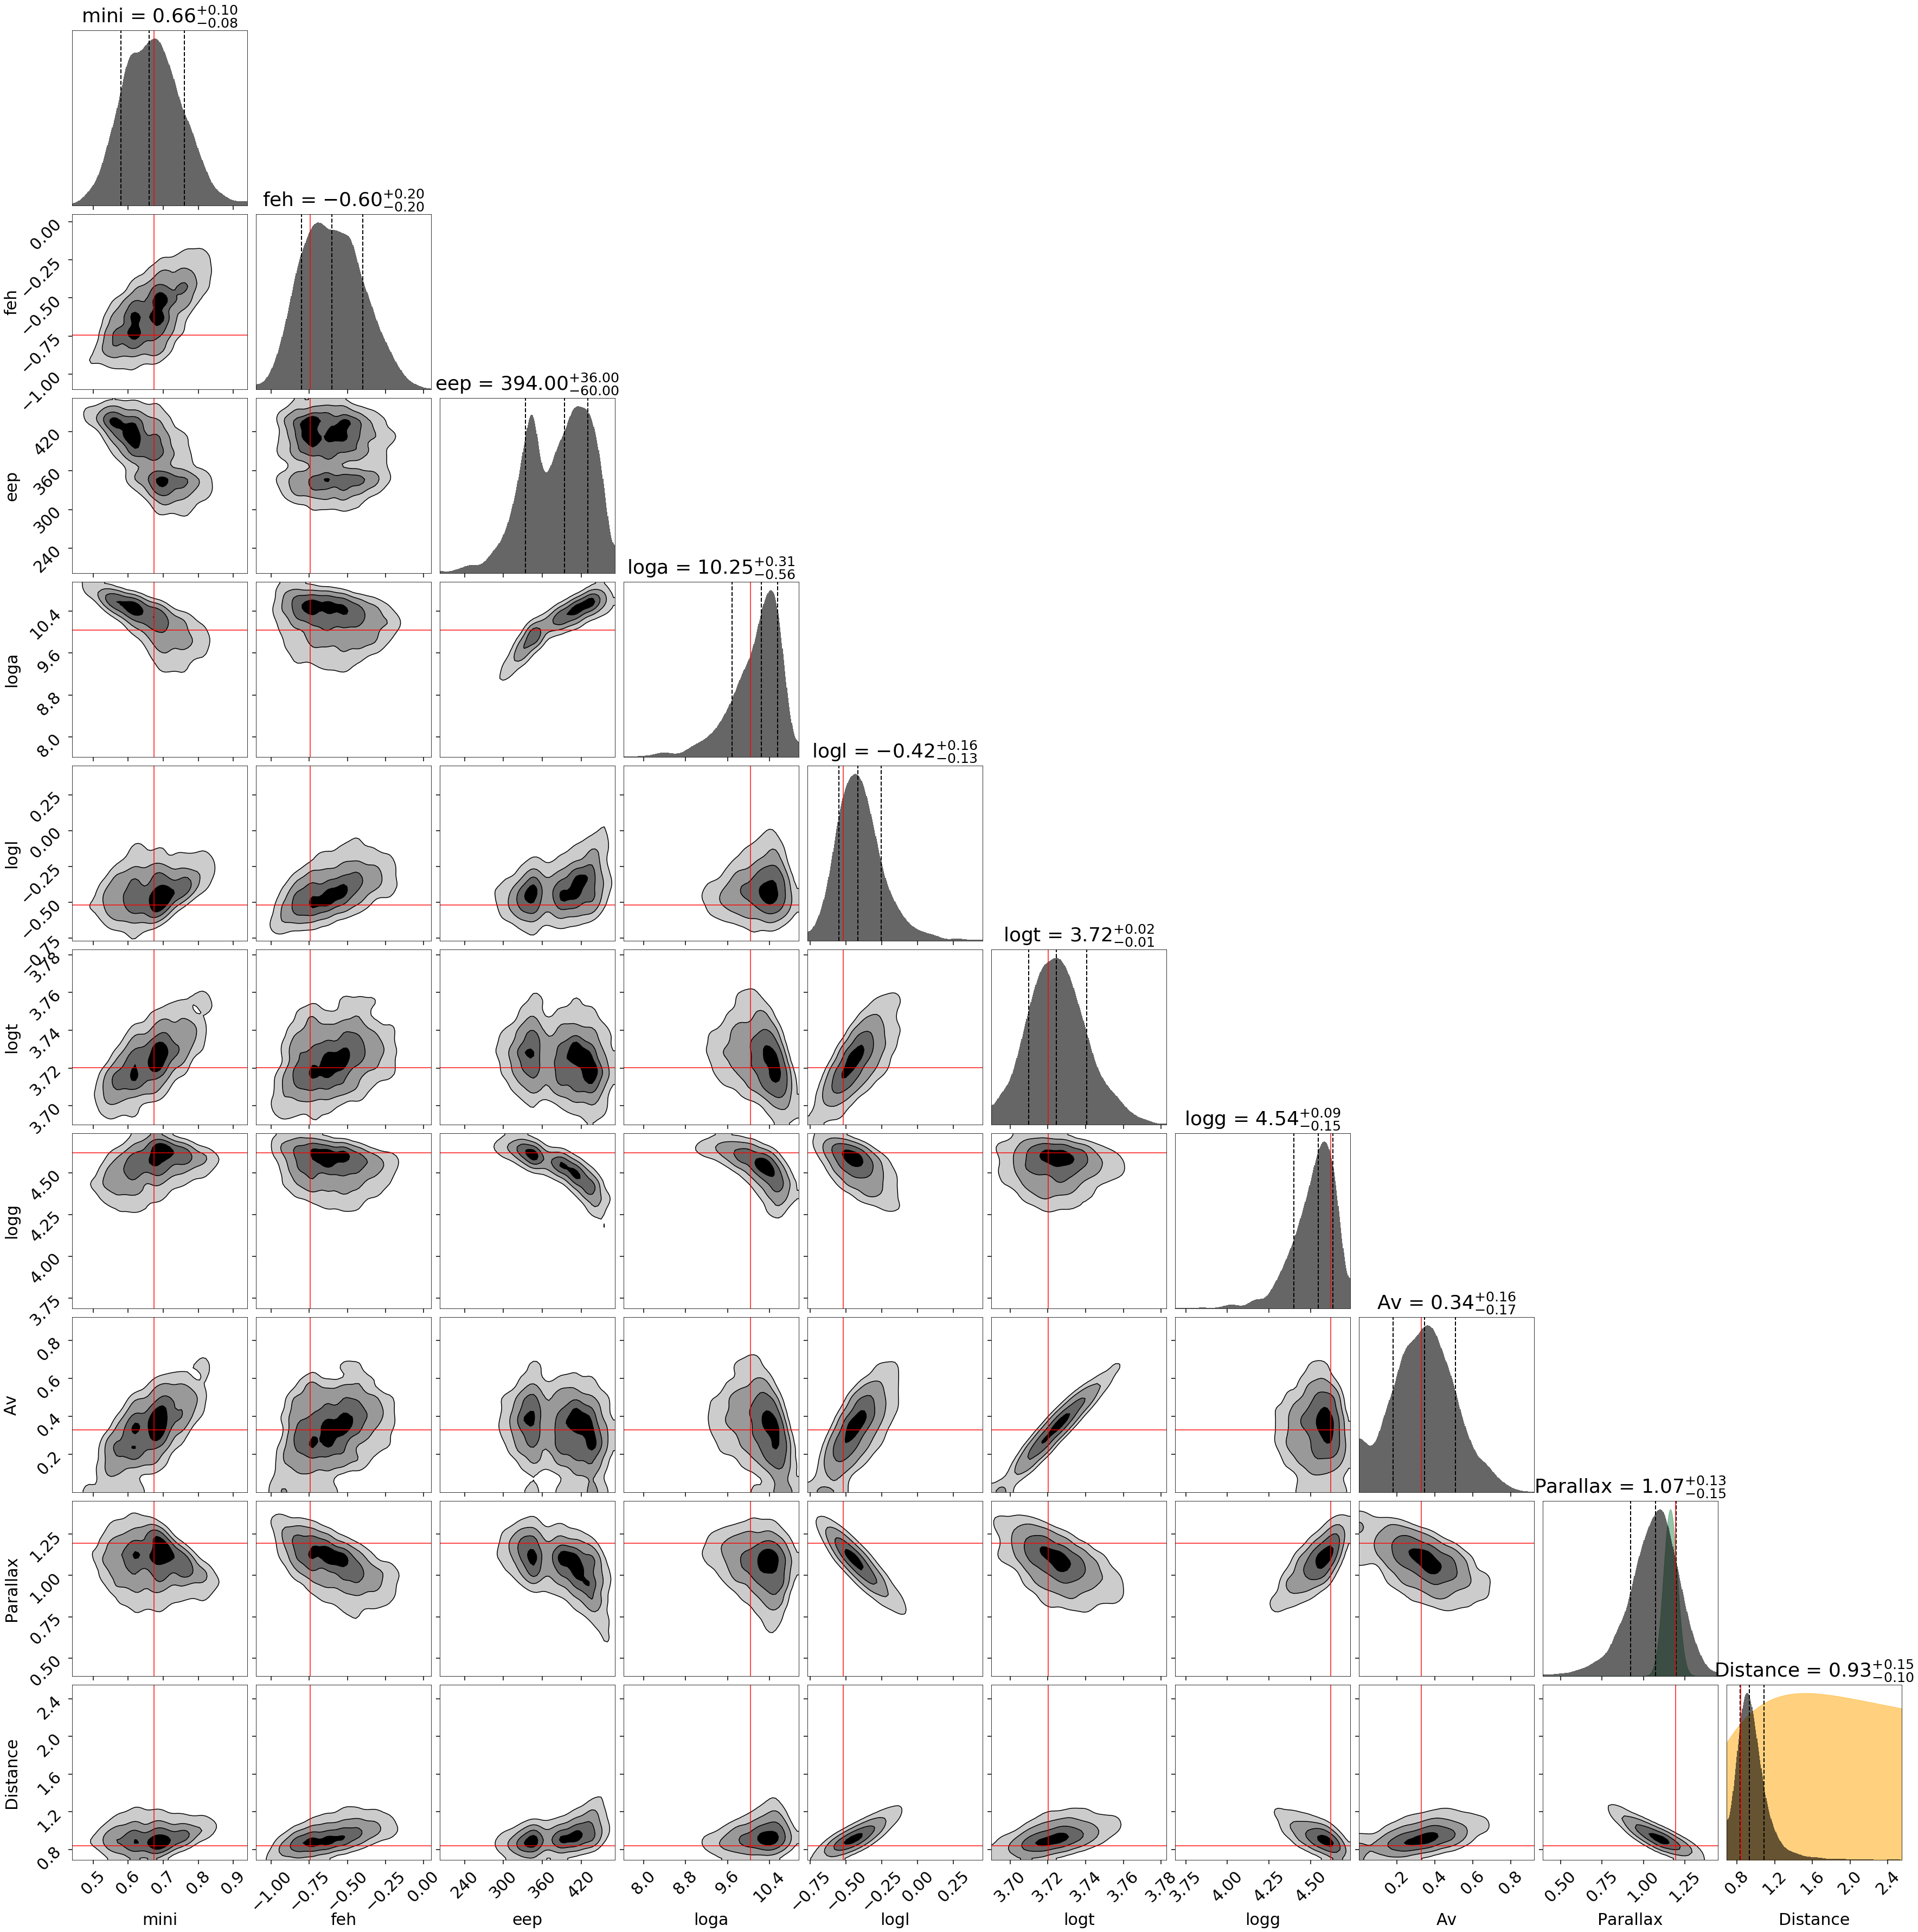

In [13]:
from brutus import plotting as bplot

i = 4
truth = (t['mass'][i], t['feh'][i], None, np.log10(t['age'][i]) + 9, 
         np.log10(t['lum'][i]), np.log10(t['teff'][i]), t['logg'][i], 
         t['a0'][i], t['parallax'][i], 1. / t['parallax'][i])

# cornerplot (without gaia)
print('Best-fit chi2:', chi2_ng[i])
# use distance and reddening draws
fig, axes = bplot.cornerplot(idxs_ng[i], (dists_ng[i], reds_ng[i]), labels, 
                             truths=truth, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))

Best-fit chi2: 25.546


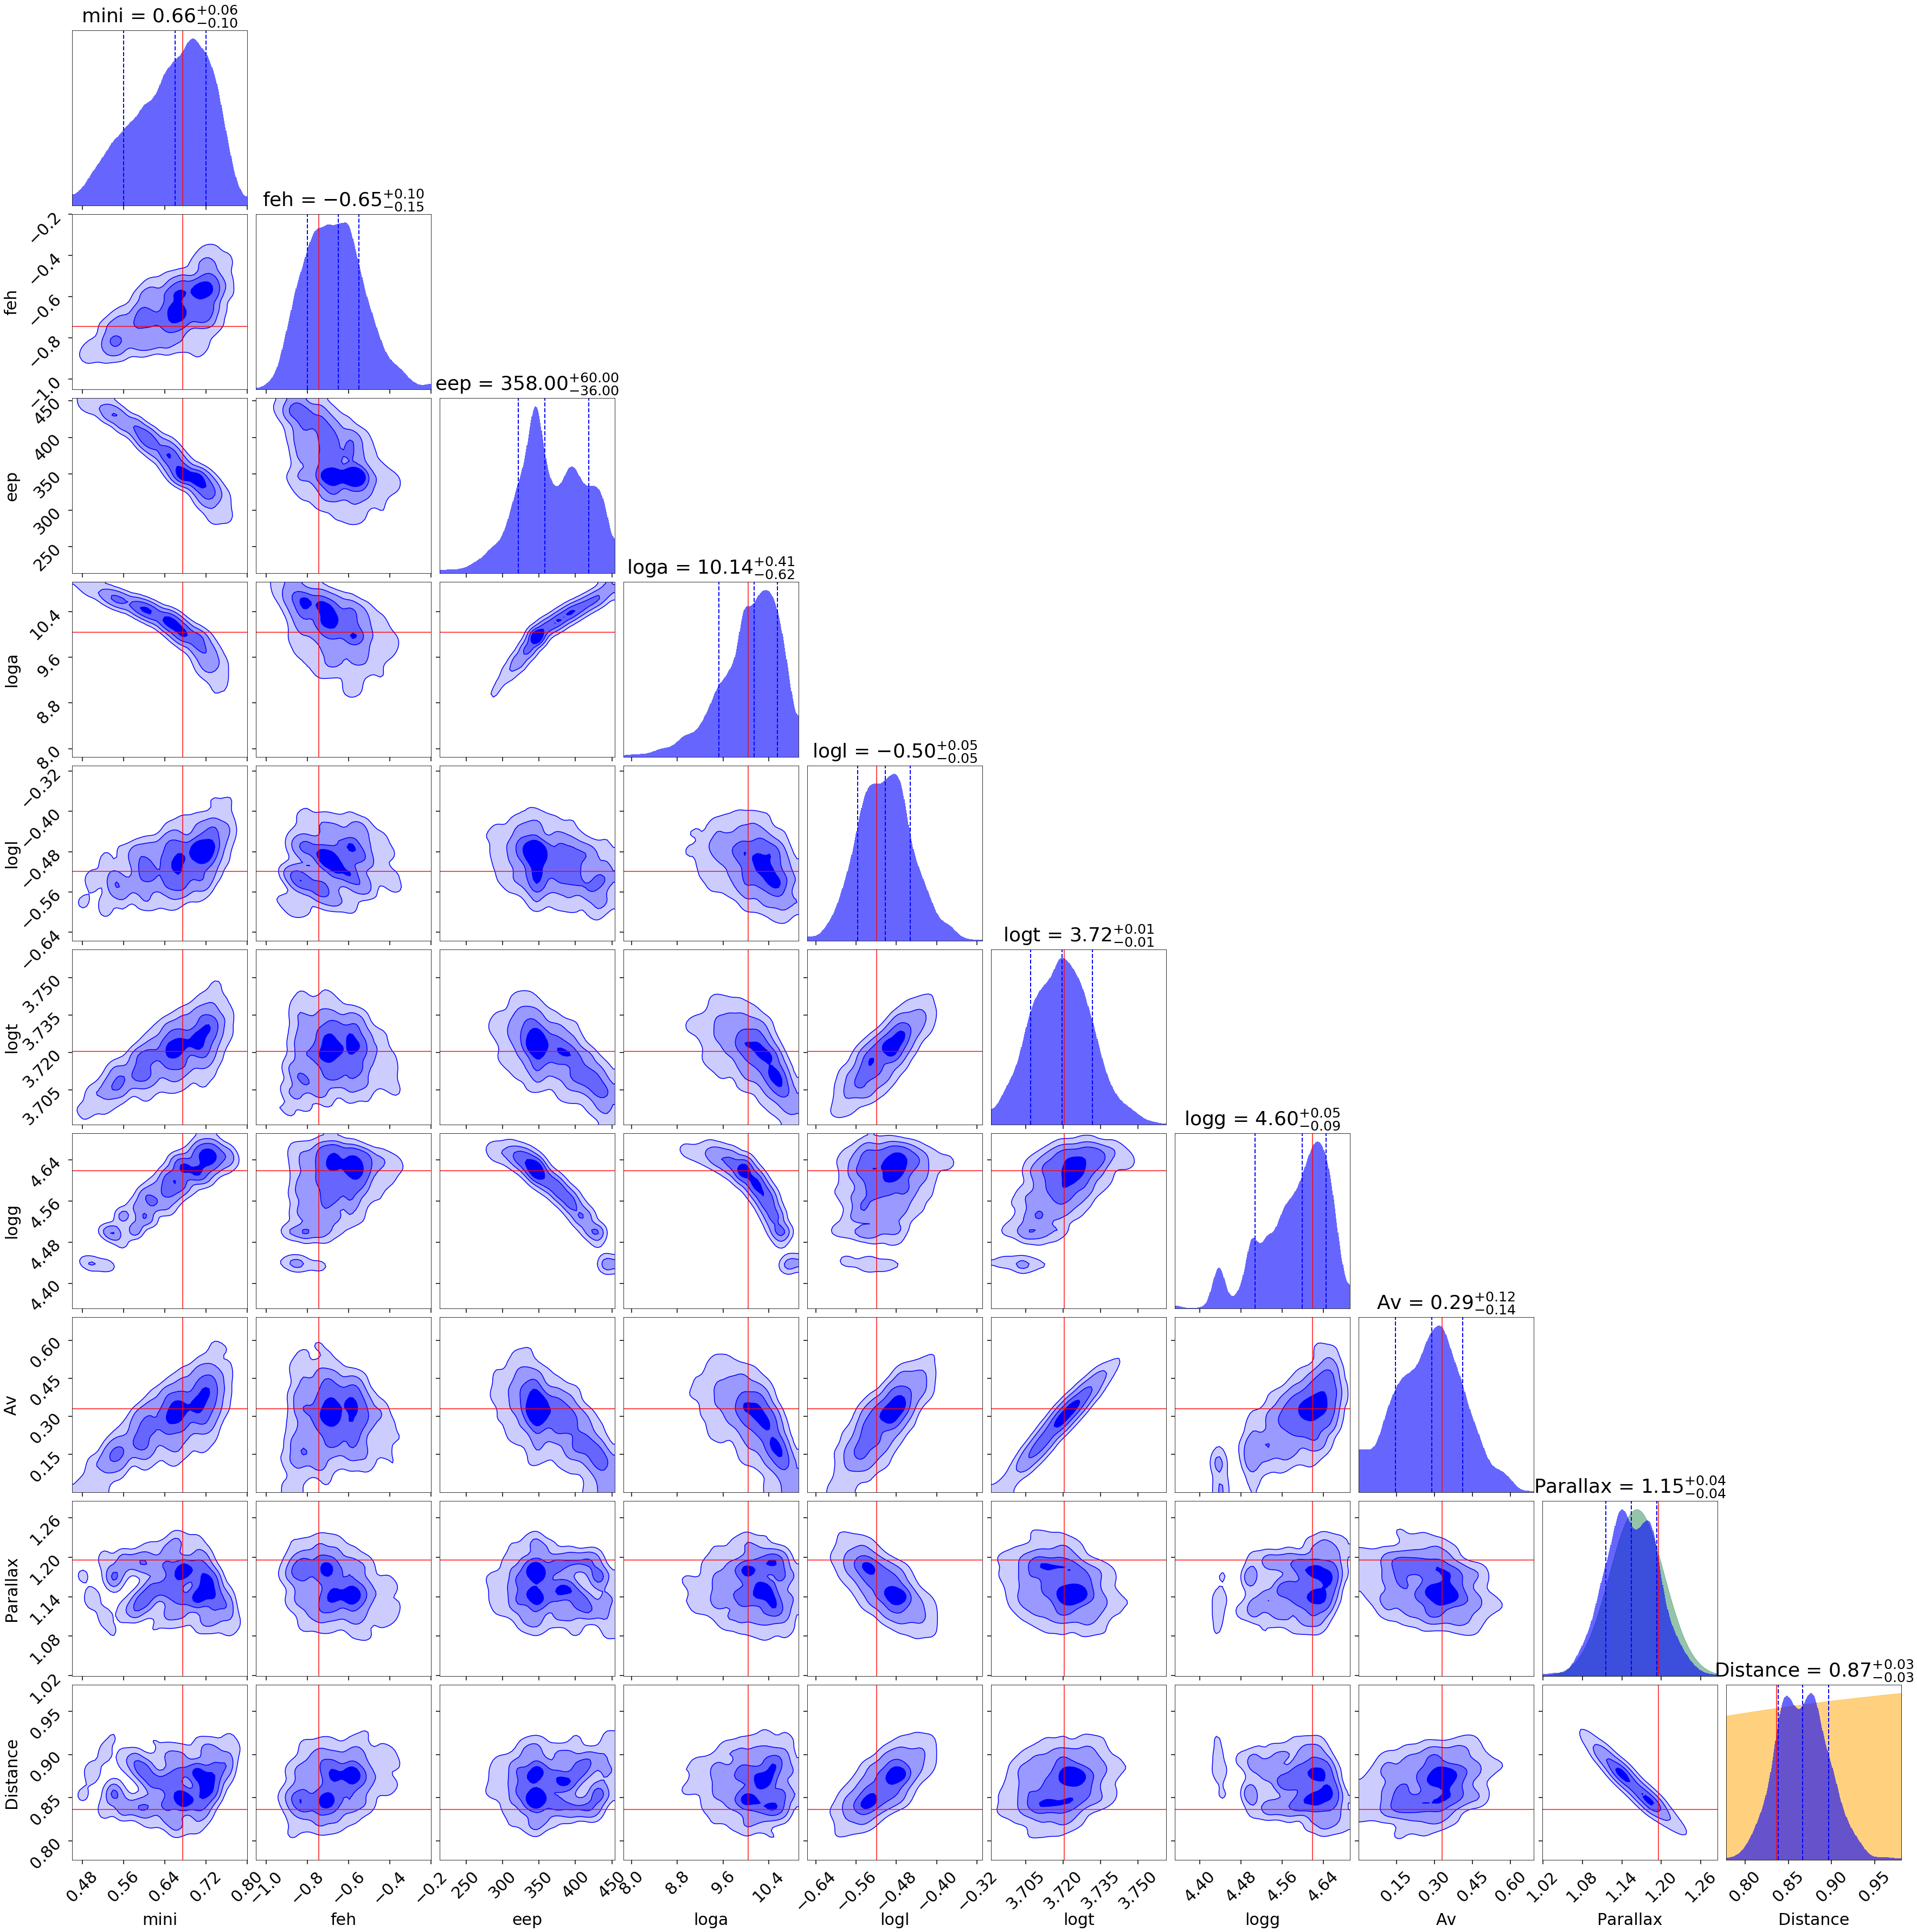

In [14]:
# cornerplot (with gaia)
print('Best-fit chi2:', chi2_yg[i])
# regenerate distance and reddening draws from (s, av, cov)
fig, axes = bplot.cornerplot(idxs_yg[i], (s_yg[i], av_yg[i], cov_yg[i]), labels, 
                             truths=truth, color='blue', coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))

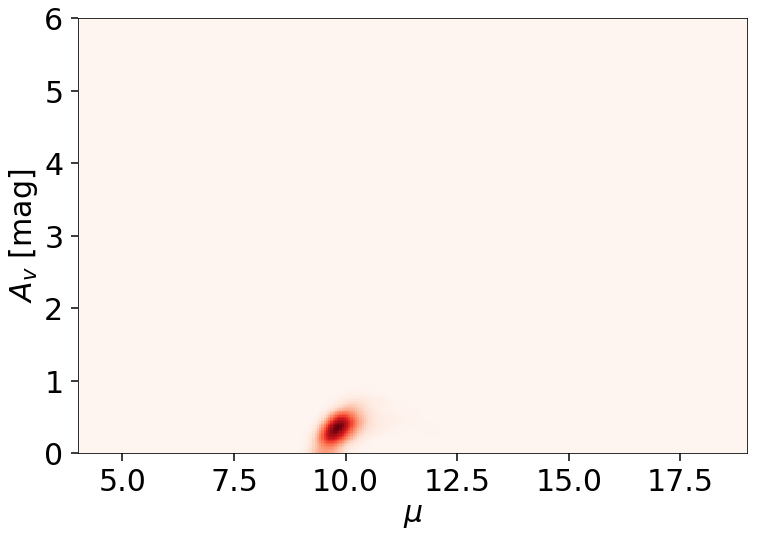

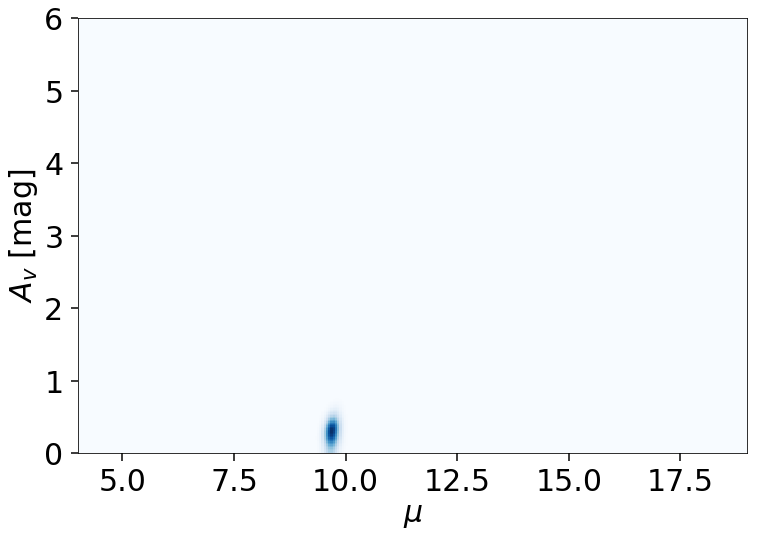

In [15]:
# compare dist vs red distributions
plt.figure(figsize=(12, 8))
# used distance and reddening draws
H, xedges, yedges, img = bplot.dist_vs_red((dists_ng[i], reds_ng[i]),
                                           cmap='Reds')

plt.figure(figsize=(12, 8))
# regenerate distance and reddening draws from (s, av, cov)
H, xedges, yedges, img = bplot.dist_vs_red((s_yg[i], av_yg[i], cov_yg[i]),
                                           coord=coords[i], cmap='Blues',
                                           parallax=parallax[i],
                                           parallax_err=parallax_err[i])